# Quickstart: Building a GenAI powered Semantic Intelligence with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic layer. The semantic layer captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is Semantic Intelligence?**

A semantic layer is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

- **Profile and classify data** : Analyze your data sources to understand their structure, data types, and other characteristics.
- **Discover links & relationships among data** : Reveal meaningful connections (PK & FK) across fragmented tables.
- **Generate a business glossary & enable semantic search** : Create business-friendly terms and use them to query data with context.
- **Create a semantic intelligence layer** : Build a unified model (YAML) of your data and relationships.
- **Build unified data products** : Generate reusable SQL queries powered by the semantic layer.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
%pip install intugle

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key

# Semantic Search Configuration (Optional)
os.environ["QDRANT_URL"] = "http://localhost:6333"
os.environ["QDRANT_API_KEY"] = "" # if authorization is used
os.environ["EMBEDDING_MODEL_NAME"] = "openai:ada"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# For Azure OpenAI models
os.environ["EMBEDDING_MODEL_NAME"] = "azure_openai:ada"
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-openai-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-azure-openai-endpoint"
os.environ["OPENAI_API_VERSION"] = "your-openai-api-version"


> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Knowledge Base

The `KnowledgeBuilder` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

In [3]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f"./sample_data/fmcg/{table_name}.csv",
        "type": "csv",
    }


table_names = [
"ad_spends",
"comp_price",
"cons_fb",
"disti",
"mkt_coverage",
"prd_mstr",
"price_sense",
"pric_strat",
"promo_camp",
"retail_audit",
"rnd",
"sales",
"social",
]

datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `KnowledgeBuilder` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [4]:
from intugle import KnowledgeBuilder

# Initialize the knowledge builder
kb = KnowledgeBuilder(datasets, domain="Fast Moving Consumer Goods")

# Run the prediction
kb.build()

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


Found existing YAML for 'ad_spends'. Checking for staleness.
ad_spends loaded
Found existing YAML for 'comp_price'. Checking for staleness.
comp_price loaded
Found existing YAML for 'cons_fb'. Checking for staleness.
cons_fb loaded
Found existing YAML for 'disti'. Checking for staleness.
disti loaded
Found existing YAML for 'mkt_coverage'. Checking for staleness.
mkt_coverage loaded
Found existing YAML for 'prd_mstr'. Checking for staleness.
prd_mstr loaded
Found existing YAML for 'price_sense'. Checking for staleness.
price_sense loaded
Found existing YAML for 'pric_strat'. Checking for staleness.
pric_strat loaded
Found existing YAML for 'promo_camp'. Checking for staleness.
promo_camp loaded
Found existing YAML for 'retail_audit'. Checking for staleness.
retail_audit loaded
Found existing YAML for 'rnd'. Checking for staleness.
rnd loaded
Found existing YAML for 'sales'. Checking for staleness.
sales loaded
Found existing YAML for 'social'. Checking for staleness.
social loaded


Starting profiling and key identification stage...

Dataset 'ad_spends' already profiled. Skipping.
Dataset 'comp_price' already profiled. Skipping.
Dataset 'cons_fb' already profiled. Skipping.
Dataset 'disti' already profiled. Skipping.
Dataset 'mkt_coverage' already profiled. Skipping.
Dataset 'prd_mstr' already profiled. Skipping.
Dataset 'price_sense' already profiled. Skipping.
Dataset 'pric_strat' already profiled. Skipping.
Dataset 'promo_camp' already profiled. Skipping.
Dataset 'retail_audit' already profiled. Skipping.
Dataset 'rnd' already profiled. Skipping.
Dataset 'sales' already profiled. Skipping.
Dataset 'social' already profiled. Skipping.


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'ad_spends' already processed. Skipping analysis.
Dataset 'comp_price' already processed. Skipping analysis.
Dataset 'cons_fb' already processed. Skipping analysis.
Dataset 'disti' already processed. Skipping analysis.
Dataset 'mkt_coverage' already processed. Skipping analysis.
Dataset 'prd_mstr' already processed. Skipping analysis.
Dataset 'price_sense' already processed. Skipping analysis.
Dataset 'pric_strat' already processed. Skipping analysis.
Dataset 'promo_camp' already processed. Skipping analysis.
Dataset 'retail_audit' already processed. Skipping analysis.
Dataset 'rnd' already processed. Skipping analysis.
Dataset 'sales' already processed. Skipping analysis.
Dataset 'social' already processed. Skipping analysis.
LinkPredictor initialized with datasets: ['ad_spends', 'comp_price', 'cons_fb', 'disti', 'mkt_coverage', 'prd_mstr', 'price_sense', 'pric_strat', 'promo_camp', 'retail_audit', 'rnd', 'sales', 'social']

--- Comparing 'ad_spends' <=> 'comp_price' ---


[*] ad_spends <==> comp_price Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'cons_fb' ---


[*] ad_spends <==> cons_fb Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'disti' ---


[*] ad_spends <==> disti Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'mkt_coverage' ---


[*] ad_spends <==> mkt_coverage Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'prd_mstr' ---


[*] ad_spends <==> prd_mstr Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'price_sense' ---


[*] ad_spends <==> price_sense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'pric_strat' ---


[*] ad_spends <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'promo_camp' ---


[*] ad_spends <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'retail_audit' ---


[*] ad_spends <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'rnd' ---


[*] ad_spends <==> rnd Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'sales' ---


[*] ad_spends <==> sales Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'ad_spends' <=> 'social' ---


[*] ad_spends <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 potential link(s).

--- Comparing 'comp_price' <=> 'cons_fb' ---


[*] comp_price <==> cons_fb Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 potential link(s).

--- Comparing 'comp_price' <=> 'disti' ---


[*] comp_price <==> disti Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'mkt_coverage' ---


[*] comp_price <==> mkt_coverage Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'prd_mstr' ---


[*] comp_price <==> prd_mstr Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 potential link(s).

--- Comparing 'comp_price' <=> 'price_sense' ---


[*] comp_price <==> price_sense Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 potential link(s).

--- Comparing 'comp_price' <=> 'pric_strat' ---


[*] comp_price <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 potential link(s).

--- Comparing 'comp_price' <=> 'promo_camp' ---


[*] comp_price <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'retail_audit' ---


[*] comp_price <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'rnd' ---


[*] comp_price <==> rnd Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'sales' ---


[*] comp_price <==> sales Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


No links found for this pair.

--- Comparing 'comp_price' <=> 'social' ---


[*] comp_price <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'cons_fb' <=> 'disti' ---


[*] cons_fb <==> disti Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'mkt_coverage' ---


[*] cons_fb <==> mkt_coverage Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'prd_mstr' ---


[*] cons_fb <==> prd_mstr Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'price_sense' ---


[*] cons_fb <==> price_sense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'pric_strat' ---


[*] cons_fb <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'promo_camp' ---


[*] cons_fb <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


No links found for this pair.

--- Comparing 'cons_fb' <=> 'retail_audit' ---


[*] cons_fb <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'rnd' ---


[*] cons_fb <==> rnd Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 potential link(s).

--- Comparing 'cons_fb' <=> 'sales' ---


[*] cons_fb <==> sales Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


No links found for this pair.

--- Comparing 'cons_fb' <=> 'social' ---


[*] cons_fb <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'disti' <=> 'mkt_coverage' ---


[*] disti <==> mkt_coverage Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


No links found for this pair.

--- Comparing 'disti' <=> 'prd_mstr' ---


[*] disti <==> prd_mstr Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Found 1 potential link(s).

--- Comparing 'disti' <=> 'price_sense' ---


[*] disti <==> price_sense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 potential link(s).

--- Comparing 'disti' <=> 'pric_strat' ---


[*] disti <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.03s/it]


Found 1 potential link(s).

--- Comparing 'disti' <=> 'promo_camp' ---


[*] disti <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'disti' <=> 'retail_audit' ---


[*] disti <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


No links found for this pair.

--- Comparing 'disti' <=> 'rnd' ---


[*] disti <==> rnd Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


No links found for this pair.

--- Comparing 'disti' <=> 'sales' ---


[*] disti <==> sales Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


No links found for this pair.

--- Comparing 'disti' <=> 'social' ---


[*] disti <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'mkt_coverage' <=> 'prd_mstr' ---


[*] mkt_coverage <==> prd_mstr Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'mkt_coverage' <=> 'price_sense' ---


[*] mkt_coverage <==> price_sense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 potential link(s).

--- Comparing 'mkt_coverage' <=> 'pric_strat' ---


[*] mkt_coverage <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Found 1 potential link(s).

--- Comparing 'mkt_coverage' <=> 'promo_camp' ---


[*] mkt_coverage <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'mkt_coverage' <=> 'retail_audit' ---


[*] mkt_coverage <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


No links found for this pair.

--- Comparing 'mkt_coverage' <=> 'rnd' ---


[*] mkt_coverage <==> rnd Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


No links found for this pair.

--- Comparing 'mkt_coverage' <=> 'sales' ---


[*] mkt_coverage <==> sales Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


No links found for this pair.

--- Comparing 'mkt_coverage' <=> 'social' ---


[*] mkt_coverage <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


No links found for this pair.

--- Comparing 'prd_mstr' <=> 'price_sense' ---


[*] prd_mstr <==> price_sense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 potential link(s).

--- Comparing 'prd_mstr' <=> 'pric_strat' ---


[*] prd_mstr <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'prd_mstr' <=> 'promo_camp' ---


[*] prd_mstr <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


No links found for this pair.

--- Comparing 'prd_mstr' <=> 'retail_audit' ---


[*] prd_mstr <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 potential link(s).

--- Comparing 'prd_mstr' <=> 'rnd' ---


[*] prd_mstr <==> rnd Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 potential link(s).

--- Comparing 'prd_mstr' <=> 'sales' ---


[*] prd_mstr <==> sales Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 potential link(s).

--- Comparing 'prd_mstr' <=> 'social' ---


[*] prd_mstr <==> social Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


No links found for this pair.

--- Comparing 'price_sense' <=> 'pric_strat' ---


[*] price_sense <==> pric_strat Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


No links found for this pair.

--- Comparing 'price_sense' <=> 'promo_camp' ---


[*] price_sense <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'price_sense' <=> 'retail_audit' ---


[*] price_sense <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 potential link(s).

--- Comparing 'price_sense' <=> 'rnd' ---


[*] price_sense <==> rnd Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Found 1 potential link(s).

--- Comparing 'price_sense' <=> 'sales' ---


[*] price_sense <==> sales Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 potential link(s).

--- Comparing 'price_sense' <=> 'social' ---


[*] price_sense <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


No links found for this pair.

--- Comparing 'pric_strat' <=> 'promo_camp' ---


[*] pric_strat <==> promo_camp Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'pric_strat' <=> 'retail_audit' ---


[*] pric_strat <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 potential link(s).

--- Comparing 'pric_strat' <=> 'rnd' ---


[*] pric_strat <==> rnd Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 potential link(s).

--- Comparing 'pric_strat' <=> 'sales' ---


[*] pric_strat <==> sales Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 potential link(s).

--- Comparing 'pric_strat' <=> 'social' ---


[*] pric_strat <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


No links found for this pair.

--- Comparing 'promo_camp' <=> 'retail_audit' ---


[*] promo_camp <==> retail_audit Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


No links found for this pair.

--- Comparing 'promo_camp' <=> 'rnd' ---


[*] promo_camp <==> rnd Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


No links found for this pair.

--- Comparing 'promo_camp' <=> 'sales' ---


[*] promo_camp <==> sales Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


No links found for this pair.

--- Comparing 'promo_camp' <=> 'social' ---


[*] promo_camp <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


No links found for this pair.

--- Comparing 'retail_audit' <=> 'rnd' ---


[*] retail_audit <==> rnd Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


No links found for this pair.

--- Comparing 'retail_audit' <=> 'sales' ---


[*] retail_audit <==> sales Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


No links found for this pair.

--- Comparing 'retail_audit' <=> 'social' ---


[*] retail_audit <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


No links found for this pair.

--- Comparing 'rnd' <=> 'sales' ---


[*] rnd <==> sales Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


No links found for this pair.

--- Comparing 'rnd' <=> 'social' ---


[*] rnd <==> social Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


No links found for this pair.

--- Comparing 'sales' <=> 'social' ---


[*] sales <==> social Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

No links found for this pair.


Link prediction complete.

Starting business glossary generation stage...

Glossary for 'ad_spends' already exists. Skipping.

Glossary for 'comp_price' already exists. Skipping.

Glossary for 'cons_fb' already exists. Skipping.

Glossary for 'disti' already exists. Skipping.

Glossary for 'mkt_coverage' already exists. Skipping.

Glossary for 'prd_mstr' already exists. Skipping.

Glossary for 'price_sense' already exists. Skipping.

Glossary for 'pric_strat' already exists. Skipping.

Glossary for 'promo_camp' already exists. Skipping.

Glossary for 'retail_audit' already exists. Skipping.

Glossary for 'rnd' already exists. Skipping.

Glossary for 'sales' already exists. Skipping.

Glossary for 'social' already exists. Skipping.

Business glossary generation complete.

Initializing semantic search...


/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)


Semantic search initialized.


## 3. Accessing Enriched Metadata

Now that the knowledge base is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `kb.datasets` dictionary:

In [5]:
sales_dataset = kb.datasets['sales']
sales_dataset.profiling_df

,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,date,sales,date,date & time,dimension,Indicates the specific day associated with a s...,"[Sales Transaction Date, Business Timeline, Re...",200,0,120,0.600,1.0,"[2022-04-13, 2021-10-25, 2021-05-06, 2022-09-1..."
1,prod_id,sales,prod_id,alphanumeric,dimension,Identifies individual products involved in sal...,"[Product Identifier, Sales Tracking, Inventory...",200,0,100,0.500,1.0,"[P113, P193, P129, P126, P183, P103, P163, P17..."
2,vol,sales,vol,integer,measure,Measures the quantity of items sold in a speci...,"[Sales Volume, Product Demand, Transaction Qua...",200,0,93,0.465,1.0,"[743, 722, 535, 247, 118, 550, 286, 895, 232, ..."
3,amt,sales,amt,float,measure,Represents the monetary value associated with ...,"[Sales Revenue, Transaction Amount, Monetary V...",200,0,100,0.500,1.0,"[20363.13, 71897.63, 98198.75, 35223.12, 73346..."
4,return_per,sales,return_per,float,measure,Indicates the percentage of sales returned by ...,"[Product Return Rate, Customer Satisfaction Me...",200,0,88,0.440,1.0,"[2.67, 1.86, 1.83, 4.93, 3.63, 4.45, 2.64, 4.8..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:


### Visualizing Relationships

The `KnowledgeBuilder` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:


In [6]:
kb.links

[PredictedLink(from_dataset='ad_spends', from_column='camp_id', to_dataset='social', to_column='camp_id'),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='cons_fb', to_column='p_id'),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='prd_mstr', to_column='prd_id'),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='price_sense', to_column='pid'),
 PredictedLink(from_dataset='comp_price', from_column='pid', to_dataset='pric_strat', to_column='prdid'),
 PredictedLink(from_dataset='cons_fb', from_column='p_id', to_dataset='disti', to_column='prd_id'),
 PredictedLink(from_dataset='cons_fb', from_column='p_id', to_dataset='mkt_coverage', to_column='p_id'),
 PredictedLink(from_dataset='cons_fb', from_column='p_id', to_dataset='prd_mstr', to_column='prd_id'),
 PredictedLink(from_dataset='cons_fb', from_column='p_id', to_dataset='price_sense', to_column='pid'),
 PredictedLink(from_dataset='cons_fb', from_column='p_id', to_da

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

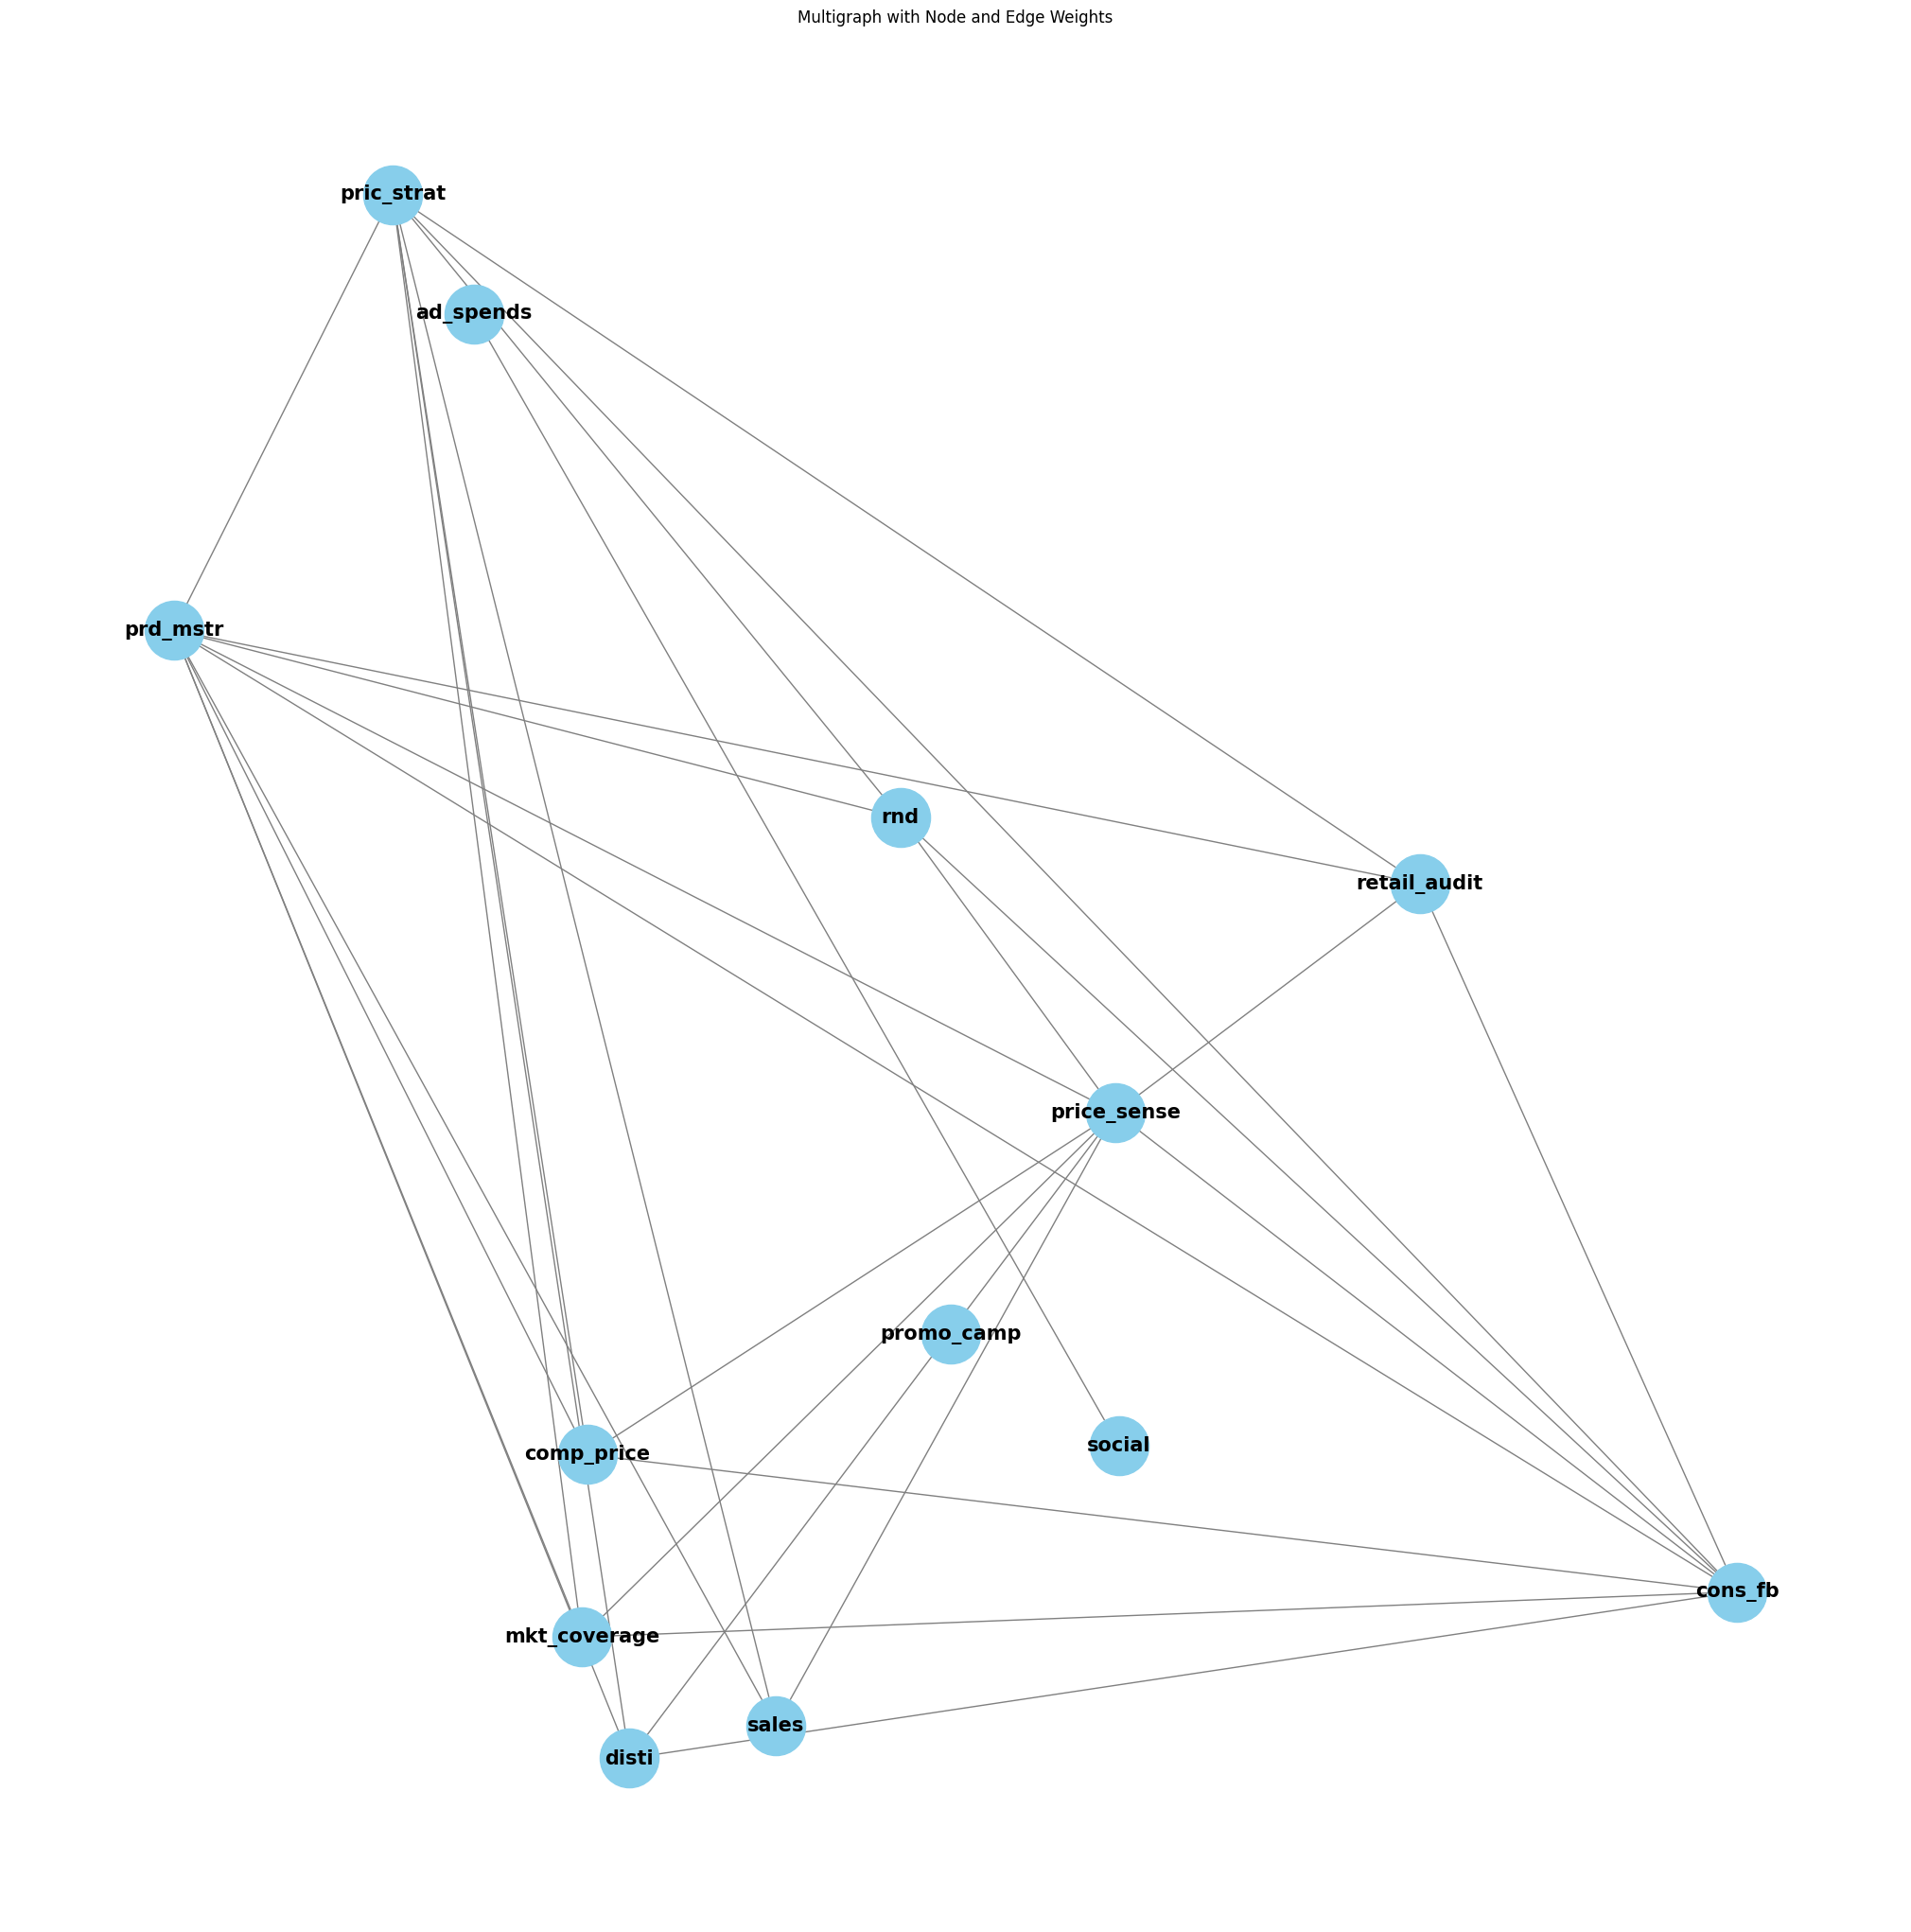

In [7]:
kb.visualize()  # To visualize the relationships as a graph


## 4. The Semantic Layer

The KnowledgeBuilder results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.


## 5. Semantic Search

The semantic search feature allows you to search for columns in your datasets using natural language. 

> **Note:** To use this feature, you need to have a running Qdrant instance and an OpenAI API key. Please refer to the [README.md](README.md) for detailed setup instructions.

Once you have built the knowledge base, you can use the `search` method to perform a semantic search. The search function returns a pandas DataFrame containing the search results, including the column's profiling metrics, category, table name, and table glossary.


In [22]:
# Perform a semantic search
search_results = kb.search("regional performance")

# View the search results
search_results

/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/intugle/data-tools/src/intugle/core/semantic_search/semantic_search.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_embedding_result_glossary["score"] = late_embedding_result_glossary["score"] / len(late_vector)


,column_id,score,relevancy,column_name,column_glossary,column_tags,category,table_name,table_glossary,uniqueness,completeness,count,null_count,distinct_count,sample_data
0,mkt_coverage.geo_cov_per,0.907056,most-relevant,geo_cov_per,Indicates the percentage of geographical area ...,"[Geographical Coverage Percentage, Market Pene...",measure,mkt_coverage,Tracks regional product availability and marke...,1.00,1.0,100,0,100,"[95.44, 94.47, 80.45, 77.16, 97.21, 55.0, 86.2..."
1,pric_strat.sales_chg,0.898194,most-relevant,sales_chg,Indicates the percentage change in sales over ...,"[Sales Performance, Revenue Trend, Percentage ...",measure,pric_strat,Tracks pricing strategies and their impact on ...,0.97,1.0,100,0,97,"[14.7, 0.54, 3.73, -1.13, 6.37, 4.96, -1.96, 4..."
2,social.reach,0.879455,most-relevant,reach,Measures the number of individuals exposed to ...,"[Audience Engagement, Social Media Metrics, Ma...",measure,social,Tracks the performance metrics of marketing ca...,0.91,1.0,100,0,91,"[201, 770, 427, 657, 691, 612, 883, 11, 63, 103]"
3,social.conv_rate,0.879455,most-relevant,conv_rate,Measures the effectiveness of converting socia...,"[Conversion Rate, Marketing Performance, Custo...",measure,social,Tracks the performance metrics of marketing ca...,0.94,1.0,100,0,94,"[3.46, 4.77, 0.14, 5.56, 6.74, 0.11, 1.53, 9.6..."
4,sales.return_per,0.876651,most-relevant,return_per,Indicates the percentage of sales returned by ...,"[Product Return Rate, Customer Satisfaction Me...",measure,sales,Tracks the performance of products over time b...,0.44,1.0,200,0,88,"[2.67, 1.86, 1.83, 4.93, 3.63, 4.45, 2.64, 4.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,rnd.prod_id,0.814455,relevant,prod_id,Identifies individual products for research an...,"[Product Identification, Inventory Tracking, S...",dimension,rnd,"Tracks research and development initiatives, i...",0.84,1.0,100,0,84,"[P167, P140, P119, P131, P109, P165, P183, P11..."
60,disti.prd_id,0.814116,relevant,prd_id,Identifies individual products within the dist...,"[Product Identifier, Inventory Tracking, Distr...",dimension,disti,"Categorizes distribution channels, evaluates o...",0.81,1.0,100,0,81,"[P139, P106, P160, P156, P140, P115, P146, P13..."
61,rnd.prj_id,0.814076,relevant,prj_id,Identifies research and development projects w...,"[Research And Development, Project Identifier,...",dimension,rnd,"Tracks research and development initiatives, i...",1.00,1.0,100,0,100,"[RD120, RD195, RD186, RD161, RD167, RD173, RD1..."
62,rnd.result,0.813362,relevant,result,Outcome of a research and development activity...,"[Outcome Classification, Performance Evaluatio...",dimension,rnd,"Tracks research and development initiatives, i...",0.03,1.0,100,0,3,"[Success, Failure, Partial Success]"


## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProductBuilder, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [19]:
data_product_config = \
{
  "name": "competitor_pricing_by_product",
  "fields": [
    {
      "id": "prd_mstr.name",
      "name": "product_name"
    },
    {
      "id": "comp_price.comp_name",
         "name": "competitor_name"
       },
       {
         "id": "comp_price.price",
         "name": "competitor_price"
       }
     ],
     "filter": {
       "sort_by": [
         {
           "id": "prd_mstr.name",
           "direction": "asc"
         },
         {
           "id": "comp_price.price",
           "direction": "desc"
         }
       ]
     }
   }

Now, let's use the `DataProductBuilder` to generate the data product:

In [20]:
from intugle.dp_builder import DataProductBuilder

# Create a DataProductBuilder
dp_builder = DataProductBuilder()

# Generate the data product
data_product = dp_builder.build(data_product_config)

data_product.to_df()


Found existing YAML for 'retail_audit'. Checking for staleness.
retail_audit loaded
Found existing YAML for 'rnd'. Checking for staleness.
rnd loaded
Found existing YAML for 'promo_camp'. Checking for staleness.
promo_camp loaded
Found existing YAML for 'ad_spends'. Checking for staleness.
ad_spends loaded
Found existing YAML for 'social'. Checking for staleness.
social loaded
Found existing YAML for 'pric_strat'. Checking for staleness.
pric_strat loaded
Found existing YAML for 'disti'. Checking for staleness.
disti loaded
Found existing YAML for 'prd_mstr'. Checking for staleness.
prd_mstr loaded
Found existing YAML for 'mkt_coverage'. Checking for staleness.
mkt_coverage loaded
Found existing YAML for 'price_sense'. Checking for staleness.
price_sense loaded
Found existing YAML for 'cons_fb'. Checking for staleness.
cons_fb loaded
Found existing YAML for 'sales'. Checking for staleness.
sales loaded
Found existing YAML for 'comp_price'. Checking for staleness.
comp_price loaded
comp

,product_name,competitor_name,competitor_price
0,Product 10,Competitor A,78.48
1,Product 11,Competitor A,54.60
2,Product 12,Competitor A,96.25
3,Product 13,Competitor A,44.17
4,Product 14,Competitor A,28.23
...,...,...,...
95,Product 87,Competitor C,32.76
96,Product 88,Competitor C,49.77
97,Product 89,Competitor C,58.54
98,Product 9,Competitor A,45.96


The `generate_product` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:


In [21]:
# The generated SQL query
data_product.sql_query



'SELECT "prd_mstr"."name" as product_name, "comp_price"."comp_name" as competitor_name, "comp_price"."price" as competitor_price FROM comp_price LEFT JOIN prd_mstr ON "comp_price"."pid" = "prd_mstr"."prd_id" ORDER BY prd_mstr.name ASC , comp_price.price DESC'

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a knowledge base using the `KnowledgeBuilder`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Perform semantic search on your knowledge base.
*   Generate data products from the semantic layer using the `DataProductBuilder`.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.